# Task 1: Data Prepping

## 1.1 - Loading the data 

- **_[TO DO]_**: Load the climate data from LAB1 (5 Danish cities between 1980-2018), and store them into Pandas data frames.
- **_[TO DO]_**: Have a quick overview of the downloaded dataset and make sure to understand the variables contained in the dataframe. Pay particular attention to the DateTime. 

**[HINT]:** In this case, the index of the dataframe is not an integer (i.e., 0, 1, 2,...) as seen in the previous lab. But we have a multiple index (MultiIndex) [pandas.DataFrame.xs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html). Check the website to see how select the data of the desidered city.
    


In [1]:
###########################
# Tasks:
#   Load climate data from LAB1 
#   Quick overview of the dataset:
#       - understand the variables in the dataframe
#       - check the Data time for two cities 
###########################


### TO DO
# @title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
import urllib.request
import tarfile
import zipfile



def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")


def download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
    :param download_dir:
        Directory where the downloaded file is saved.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

#########

In [2]:
# Location of the dataset on the internet.
data_url = "https://github.com/Hvass-Labs/weather-denmark/raw/master/weather-denmark.tar.gz"

# Local directory where you want to download and save the dataset.
data_dir = "weather-data/"

In [3]:
download_and_extract(url=data_url, download_dir=data_dir)

Data has apparently already been downloaded and unpacked.


In [4]:
# Location of the original data in pickle format
def path_original_data_pickle():
    return os.path.join(data_dir, "weather-denmark.pkl")
# Location of the original data in .csv
def path_original_data_csv():
    return os.path.join(data_dir, "weather-denmark.csv")

In [5]:
def load_original_data():
    return pd.read_pickle(path_original_data_pickle())

In [6]:
df = load_original_data()
df

Temp  Pressure  WindSpeed  WindDir
City     DateTime                                               
Aalborg  1980-03-01 00:00:00   5.0    1008.1       11.3    290.0
         1980-03-01 00:20:00   4.0       NaN        9.2    270.0
         1980-03-01 00:50:00   4.0       NaN        9.2    280.0
         1980-03-01 01:20:00   4.0       NaN        9.2    280.0
         1980-03-01 01:50:00   4.0       NaN        8.7    270.0
...                            ...       ...        ...      ...
Roskilde 2018-03-01 22:20:00  -5.0       NaN        5.1     70.0
         2018-03-01 22:50:00  -5.0       NaN        4.1     70.0
         2018-03-01 23:00:00  -5.3    1018.6        4.1     60.0
         2018-03-01 23:20:00  -5.0       NaN        3.6     60.0
         2018-03-01 23:50:00  -5.0       NaN        3.6     60.0

[2918150 rows x 4 columns]

## 1.2 - Data interpolation

Many time series analyses assume observations over uniform time intervals. In the real world, incoming data often does not arrive in this way. As a result, one common prerequisite for Time Series analysis is to take an initially raw input and transform it into discrete intervals, or to resample an input at one frequency into an input of a different frequency.

For instance, we plot the temperature data for the cities of Aalborg and Aarhus in the day 1st March 2018 from 00am to 12pm. We can notice that the temperature data for the two cities is not always recorded at the same time.

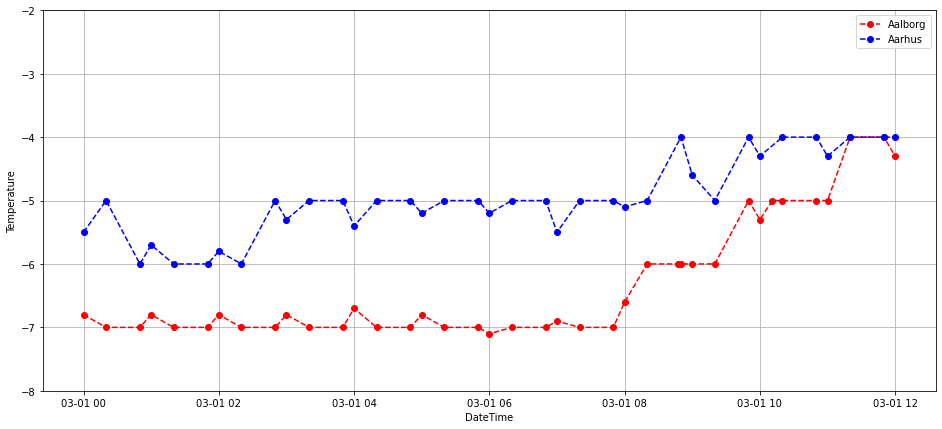

In [7]:
# List of the Danish cities in this data-set.
cities = ['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']


city_1 = df.xs(cities[0]) # choose Aalborg
city_2 = df.xs(cities[1]) # choose Aarhus


plt.figure(figsize=(16, 7))
plt.plot(city_1.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aalborg', linestyle='--', marker='o',  c='r')

plt.plot(city_2.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aarhus', linestyle='--', marker='o',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

plt.ylim([-8, -2])
plt.grid()
plt.legend()
plt.show()


As just observed, this dataset contains data recorded with an irregular interval across cities. Therefore, before continuing with the data analysis, we will [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) and [interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) the values in order to have values at a **regular interval** for all the cities and make possible a fair comparison.

In [8]:
def _resample(df):

    # Upsample in order to have data for every minute.
    df_res = df.resample('1T')

    # Interpolate through time
    df_res = df_res.interpolate(method='time')

    # Downsample to a 1-hour basis (60 minutes).
    df_res = df_res.resample('60T')

    df_res = df_res.interpolate()

    # We can remove all empty rows or leave like this for missing values analysis?
#     df_res = df_res.dropna(how='all')

    return df_res


def load_resampled_data():

    # Path for the cache-file with the resampled data.
    path = path_resampled_data_pickle()

    # Check if the cache-file already exists and load it eventually
    if os.path.exists(path):
        df = pd.read_pickle(path)
    else:
        # Otherwise resample the original data and save it in a cache-file.

        # Load the original data.
        df_org = load_original_data()

        # Split the original data into separate DataFrames for each city.
        df_cities = [df_org.xs(city) for city in cities]

        # Resample the data for each city.
        df_resampled = [_resample(df_city) for df_city in df_cities]

        # Join the resampled data into a single data-frame.
        df = pd.concat(df_resampled, keys=cities, axis=1, join='inner')

        # Save the resampled data in a cache-file for quick reloading.
        df.to_pickle(path)

    return df

In [9]:
def path_resampled_data_pickle():
    return os.path.join(data_dir, "weather-denmark-resampled.pkl")

df_resampled = load_resampled_data()
df_resampled

Aalborg                                     Aarhus  \
                         Temp     Pressure  WindSpeed     WindDir   Temp   
DateTime                                                                   
1980-03-01 10:00:00  4.333333  1007.533333  11.266667  286.666667    4.0   
1980-03-01 11:00:00  5.000000  1007.766667  10.200000  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000  10.300000  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667   9.700000  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333  11.100000  283.333333    5.0   
...                       ...          ...        ...         ...    ...   
2018-03-01 19:00:00 -4.400000  1024.200000   7.200000   70.000000   -3.6   
2018-03-01 20:00:00 -4.300000  1023.700000   6.700000   70.000000   -3.9   
2018-03-01 21:00:00 -3.900000  1023.100000   8.800000   80.000000   -3.5   
2018-03-01 22:00:00 -3.800000  1022.900000   7.200000   70.000000   -3.5   
2018-03-01 23:00:00 -4.200000  1022.500000   7.200000   70.000000   -3.4   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 10:00:00  1008.000000      14.9   290.0       NaN      NaN   
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
...                          ...       ...     ...       ...      ...   
2018-03-01 19:00:00  1022.700000       8.8    70.0 -5.000000   1022.6   
2018-03-01 20:00:00  1022.200000       8.2    60.0 -4.333333   1022.6   
2018-03-01 21:00:00  1021.700000       8.2    80.0 -5.000000   1022.6   
2018-03-01 22:00:00  1021.200000       8.2    80.0 -5.000000   1022.6   
2018-03-01 23:00:00  1021.000000       7.7    80.0 -5.333333   1022.6   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 10:00:00        NaN         NaN  5.545455  1010.933333  11.663636   
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
...                        ...         ...       ...          ...        ...   
2018-03-01 19:00:00   6.366667   70.000000 -4.400000  1020.400000   8.800000   
2018-03-01 20:00:00   6.866667   80.000000 -5.000000  1019.800000   8.200000   
2018-03-01 21:00:00   8.200000   80.000000 -5.200000  1019.200000   7.700000   
2018-03-01 22:00:00   6.366667   66.666667 -5.000000  1018.700000   8.800000   
2018-03-01 23:00:00   6.533333   60.000000 -4.700000  1018.300000   9.300000   

                                 Roskilde                                  
                        WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                                   
1980-03-01 10:00:00  285.454545       NaN      NaN        NaN         NaN  
1980-03-01 11:00:00  290.000000  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00  290.000000  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00  290.000000  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00  290.000000  5.833333      NaN  12.300000  270.000000  
...                         ...       ...      ...        ...         ...  
2018-03-01 19:00:00   60.000000 -4.400000   1020.6   6.200000   60.000000  
2018-03-01 20:00:00   60.000000 -4.600000   1019.9   

**_[TO DO]_:** Check now the previous plot after resampling and interpolation.


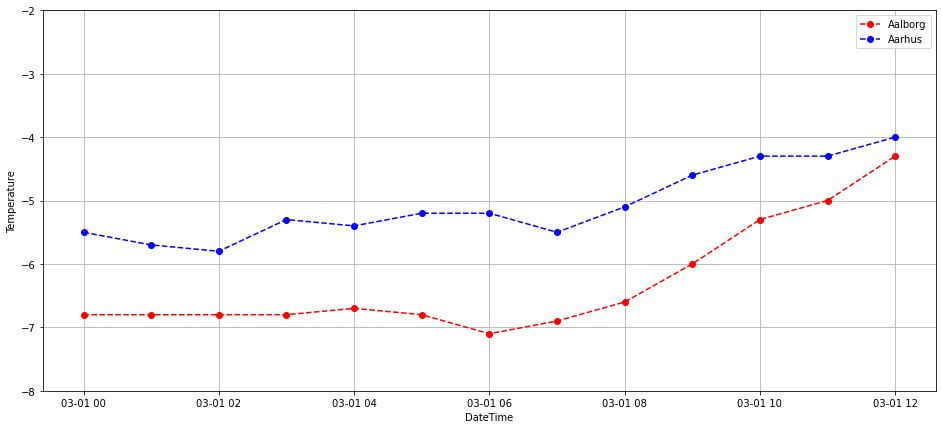

In [10]:
###########################
# Task: 
#   Plot the previous one with the new data
###########################


### TO DO
# change axis = 1 to select columns
city_resampled_1 = df_resampled.xs(cities[0], axis = 1) # choose Aalborg
city_resampled_2 = df_resampled.xs(cities[1], axis = 1) # choose Aarhus


plt.figure(figsize=(16, 7))
plt.plot(city_resampled_1.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aalborg', linestyle='--', marker='o',  c='r')

plt.plot(city_resampled_2.loc['2018-03-01 00:00:00':'2018-03-01 12:00:00', 'Temp'],
         label='Aarhus', linestyle='--', marker='o',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

plt.ylim([-8, -2])
plt.grid()
plt.legend()
plt.show()
#########

## 1.3 - Data overview

We will now analyse the statistical properties of this dataset. Since this dataset is quite big and contains weather data of almost 40 years, in order try to complete the following instructions:
- **_[TO DO]_**  extract the general statistical properties (mean, variance, min value, max value),
- **_[TO DO]_**  for each city, plot the average temperature and the wind speed variance in January for all the years (1980 to 2018) 
- **_[TO DO]_** the maximum temperature and the minimum wind speed in May 

In [11]:
###########################
# Task: 
#   extract general statistical properties
#
###########################


### TO DO

df_resampled.describe()

#########

Aalborg                                               \
                Temp       Pressure      WindSpeed        WindDir   
count  333110.000000  333110.000000  333110.000000  333110.000000   
mean        8.323675    1012.743473       4.867406     192.307074   
std         6.986639      11.690186       2.793941      88.071567   
min       -25.000000     951.900000       0.000000      10.000000   
25%         3.100000    1005.700000       2.666667     116.666667   
50%         8.100000    1013.400000       4.600000     210.000000   
75%        13.600000    1020.500000       6.700000     260.000000   
max        30.800000    1050.800000      32.900000     360.000000   

              Aarhus                                               \
                Temp       Pressure      WindSpeed        WindDir   
count  333110.000000  333110.000000  333110.000000  333110.000000   
mean        8.290577    1013.352071       4.036376     201.261096   
std         7.027572      11.277480       2.549404      82.166840   
min       -24.300000     955.500000       0.000000      10.000000   
25%         3.000000    1006.600000       2.100000     140.000000   
50%         8.000000    1014.000000       3.600000     213.333333   
75%        13.500000    1020.800000       5.600000     270.000000   
max        30.900000    1050.000000      33.400000     360.000000   

             Esbjerg                                               \
                Temp       Pressure      WindSpeed        WindDir   
count  333109.000000  332070.000000  333109.000000  333109.000000   
mean        8.537116    1013.131439       4.892615     201.758338   
std         6.743867      10.904699       2.681328      87.880378   
min       -27.000000     959.300000       0.000000      10.000000   
25%         4.000000    1006.954601       2.933333     126.666667   
50%         8.333333    1014.127073       4.516667     216.666667   
75%        13.582857    1019.861904       6.533333     273.703704   
max        54.000000    1049.300000      39.100000     360.000000   

              Odense                                               \
                Temp       Pressure      WindSpeed        WindDir   
count  333110.000000  333110.000000  333110.000000  333110.000000   
mean        8.802755    1013.805596       4.848788     195.840053   
std         6.924723      10.958942       2.768103      83.739036   
min       -22.500000     959.700000       0.000000      10.000000   
25%         3.700000    1007.300000       2.766667     126.666667   
50%         8.600000    1014.433333       4.600000     210.000000   
75%        13.950000    1021.000000       6.635696     260.000000   
max        49.900000    1048.900000      62.521795     360.000000   

            Roskilde                                               
                Temp       Pressure      WindSpeed        WindDir  
count  333109.000000  332346.000000  333109.000000  333109.000000  
mean        8.264180    1012.839357       4.835396     202.708912  
std         7.124592      11.739851       2.755634      86.188538  
min       -21.833333     959.800000       0.000000      10.000000  
25%         3.000000    1006.100000       2.766667     130.000000  
50%         8.000000    1013.833333       4.433333     220.000000  
75%        13.700000    1020.700000       6.574359     270.000000  
max        32.000000    1048.100000      25.000000     360.000000

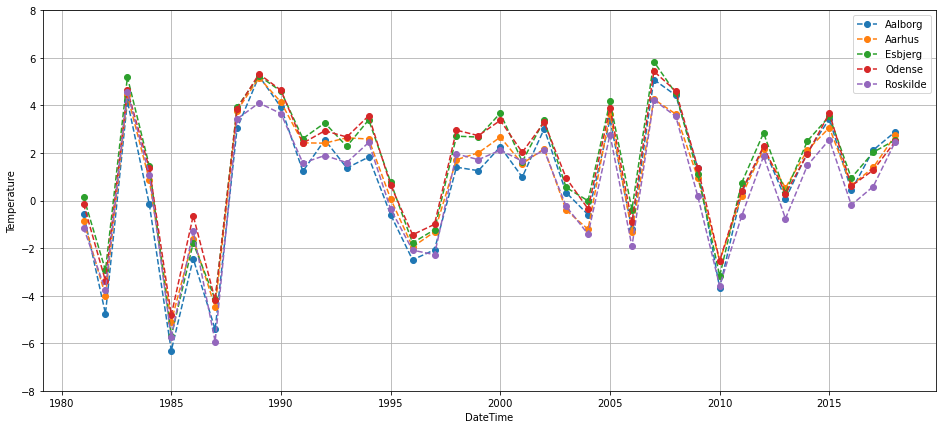

In [12]:
###########################
# Task: 
#   plot average temperature in January from 1980 to 2018.
#
###########################


### TO DO
# only select january datetimes in the dataset
df_jan = df_resampled[df_resampled.index.month == 1]
# Calculate mean for every variable for jan in each year
df_jan_temp_mean = df_jan.groupby(by = df_jan.index.year).mean()

plt.figure(figsize=(16, 7))
for city in cities:
    city_jan_temp_mean = df_jan_temp_mean.xs((city, 'Temp'), axis = 1)
    plt.plot(city_jan_temp_mean, label=city, linestyle='--', marker='o')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

plt.ylim([-8, 8])
plt.grid()
plt.legend()
plt.show()

#########

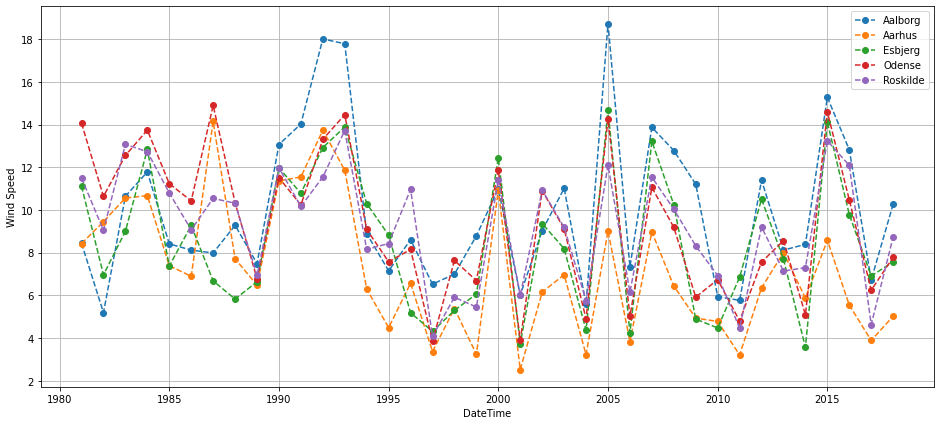

In [13]:
###########################
# Task: 
#   plot average wind speed variance in January from 1980 to 2018.
#
###########################


### TO DO
# Calculate variance for every variable for jan in each year
df_jan_wind_var = df_jan.groupby(by = df_jan.index.year).var()

plt.figure(figsize=(16, 7))
for city in cities:
    city_jan_wind_var = df_jan_wind_var.xs((city, 'WindSpeed'), axis = 1)
    plt.plot(city_jan_wind_var, label=city, linestyle='--', marker='o')

plt.xlabel('DateTime')
plt.ylabel('Wind Speed')

# plt.ylim([0, 20])
plt.grid()
plt.legend()
plt.show()

#########

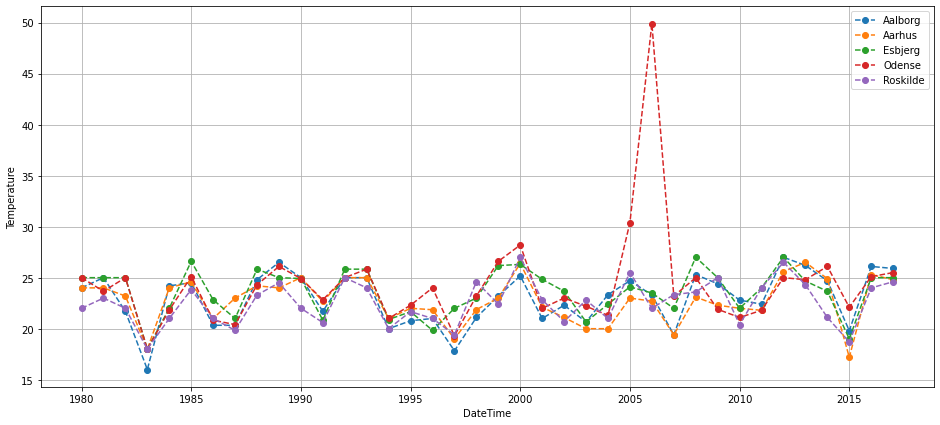

In [14]:
###########################
# Task: 
#   plot maximum temperature in May from 1980 to 2018.
#
###########################


## TO DO
# only select may datetimes in the dataset
df_may = df_resampled[df_resampled.index.month == 5]
# Calculate max for every variable for jan in each year
df_may_temp_max = df_may.groupby(by = df_may.index.year).max()

plt.figure(figsize=(16, 7))
for city in cities:
    city_jan_temp_max = df_may_temp_max.xs((city, 'Temp'), axis = 1)
    plt.plot(city_jan_temp_max, label=city, linestyle='--', marker='o')

plt.xlabel('DateTime')
plt.ylabel('Temperature')

# plt.ylim([-8, 8])
plt.grid()
plt.legend()
plt.show()

#########

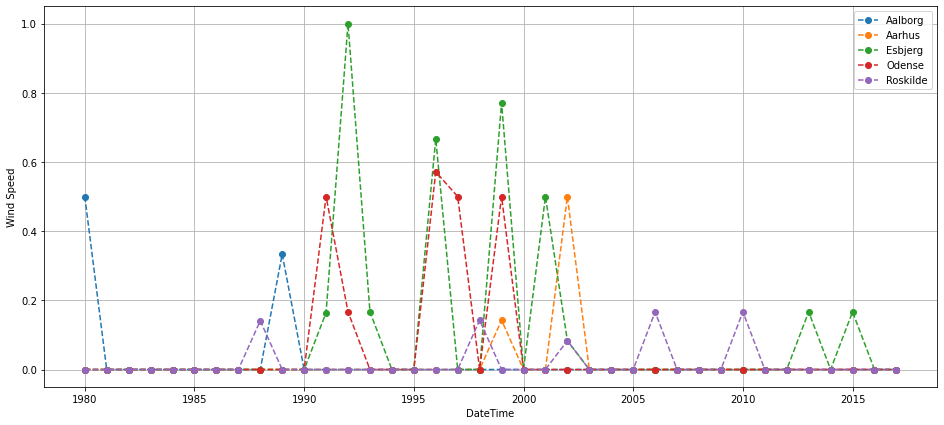

In [15]:
###########################
# Task: 
#   plot minimum wind speed in May from 1980 to 2018.
#
###########################


### TO DO

# Calculate min for every variable for may in each year
df_may_wind_min = df_may.groupby(by = df_may.index.year).min()

plt.figure(figsize=(16, 7))
for city in cities:
    city_may_wind_min = df_may_wind_min.xs((city, 'WindSpeed'), axis = 1)
    plt.plot(city_may_wind_min, label=city, linestyle='--', marker='o')

plt.xlabel('DateTime')
plt.ylabel('Wind Speed')

# plt.ylim([0, 20])
plt.grid()
plt.legend()
plt.show()

#########

**NOTE:** Look at the scale of the previous plots. Do you think all those zeros actually mean that there was no wind at all?

## 1.4 - Outliers

In the plots you can notice there is definitely an outlier (you could also identify it using the general properties of the dataset as well). 

This is quite a common case one can encounter while dealing with big datasets. Such inconsistancyin the data is likely to affect our inference about the general statistics behind the data. **How to detect such outliers?**


### 1.4.1 Using visualisation tools

The very first method is to spot outliers by using your eyes. For example, open your data and find a
datapoint is clearly different from others. Let's look at different visualisation toos.


#### 1.4.1.1 Box Plot
Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”):

![](Figures/box_plot.png)

**median (Q2/50th Percentile)**: the middle value of the dataset.

**first quartile (Q1/25th Percentile)**: the middle number between the smallest number (not the “minimum”) and the median of the dataset.

**third quartile (Q3/75th Percentile)**: the middle value between the median and the highest value (not the “maximum”) of the dataset.

**interquartile range (IQR)**: 25th to the 75th percentile.

**“maximum”**: $Q3 + 1.5*IQR$

**“minimum”**: $Q1 -1.5*IQR$

**whiskers** (shown in blue)

**outliers** (shown as green circles)

Back to our max temperature example, let's box-plot and find out the outlier in the data we used to plot "The max temperature in May - city of Odense".

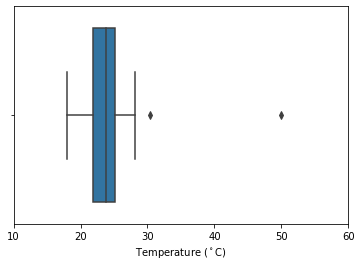

In [16]:
import seaborn as sns

# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.

outlier_dataset = np.array(df_may_temp_max.xs((cities[3], 'Temp'), axis = 1))
outlier_year = np.array(df_may_temp_max.index)

# plot with specifying the x, y parameters, if not error will occur
sns.boxplot(x = outlier_dataset)
    
# box plot
plt.xlabel(r'Temperature ($^\circ$C)')
plt.xlim([10, 60])
plt.show()

As you can see, besides the outlier temperature 50 degrees, there is another outlier temperature around 31 degrees. Is it really an outlier? For 31 degres, it is ambiguous whether it is an outlier or variance.

#### 1.4.1.2 Scatter Plot
A scatter plot is the collection of points that shows values for two variables. 



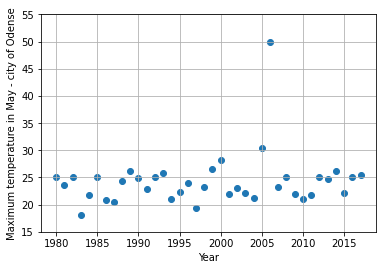

In [17]:
# scatter plot: x=year,y=value
plt.scatter(outlier_year,outlier_dataset)
plt.xlabel('Year')
plt.ylabel('Maximum temperature in May - city of Odense')
plt.ylim([15, 55])
plt.grid()
plt.show()

Observe how the data point around 50 degrees seems to clearly deviate from the general case.

### 1.4.2 Using statistics

Statistical methods can also be very useful to detec outliers. Let's look at some examples.

#### 1.4.2.1 Z-score
The Z-score is the signed number of standard deviations, calculated by following equation:

$z=\frac{x-\overline{x}}{S}$

where $\overline{x}$ is the mean value, $S$ is the standard deviation.

Let's see how it works in python.

z score of the dataset is:
 [1.42126640e-01 1.32898813e-01 1.42126640e-01 1.30175699e+00
 5.11058811e-01 1.62753549e-01 7.17327900e-01 8.06711173e-01
 2.26172248e-03 3.69022639e-01 1.24937550e-01 3.04789721e-01
 1.42126640e-01 3.14017549e-01 6.82949719e-01 4.14799902e-01
 6.41424494e-02 1.03360717e+00 2.29157721e-01 4.72157184e-01
 8.02187728e-01 4.76680629e-01 2.70411539e-01 4.35426811e-01
 6.21068992e-01 1.25597973e+00 5.27822698e+00 2.29157721e-01
 1.42126640e-01 4.97307538e-01 6.62322810e-01 5.17934447e-01
 1.42126640e-01 1.00872822e-01 3.69022639e-01 4.56053720e-01
 1.62753549e-01 2.45261185e-01]


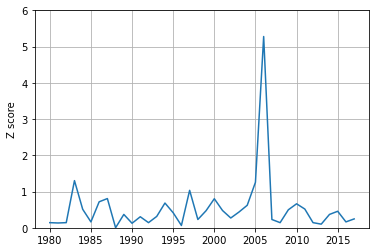

In [18]:
from scipy import stats
# calc the abs value of z-score
z = np.abs(stats.zscore(outlier_dataset))

print('z score of the dataset is:\r\n',z)

plt.plot(outlier_year,z)
plt.grid()
plt.ylim([0, 6])
plt.ylabel('Z score')
plt.show()


But, then what? how can we find outlier using these z-scores?

In general, we **put a threshold on z-scores**. Typically, the threshold is 3.
If $|z\_score|>3$, then it is an outlier.

In [19]:
# set a threshold and find the location where the value meets our condition(s)
threshold = 3
outlier_loc = np.where(z > threshold)

# find the outlier value given its index
outlier_by_Z_Score = outlier_dataset[outlier_loc]
print('the data classified as outlier by z score:\r\n', outlier_by_Z_Score)
print('the year of the outlier is:\r\n', outlier_year[outlier_loc])

the data classified as outlier by z score:
 [49.9]
the year of the outlier is:
 [2006]


#### 1.4.2.2   IQR score
Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

In [20]:
Q1 = np.quantile(outlier_dataset,0.25)
Q3 = np.quantile(outlier_dataset,0.75)
IQR = Q3-Q1
Minimum = Q1-1.5*IQR
Maximum = Q3+1.5*IQR

# find values that meets the conditions: (outlier_dataset<Minimum) or (outlier_dataset>Maximum)
outlier_by_IQR_Score=outlier_dataset[(outlier_dataset<Minimum) | (outlier_dataset>Maximum)]
print('The data classified as outlier by IQR score:\r\n', outlier_by_IQR_Score)

The data classified as outlier by IQR score:
 [30.4 49.9]


## 1.4.3 What to do with outliers?

Now that we have ways to detecting outliers, what should we do with them? Let's go through a few potential solutions. 

### 1.4.3.1 Drop them
Simply drop the outliers as long as we have sufficient amount of data left.

Assume we have detected the outlier using z score. We can then drop it easily.

Before Drop, the dataset has shape:
 (38,)
After Drop, the dataset has shape:
 (37,)


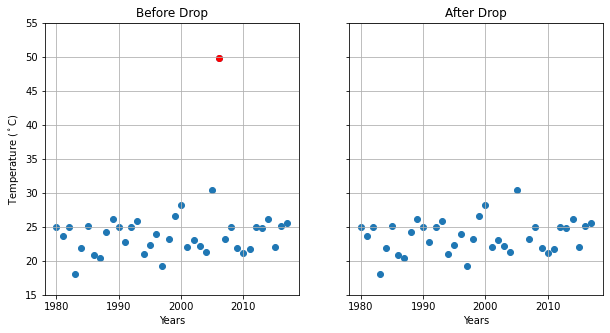

In [21]:
# find values that meet the conditions: outlier_dataset != outlier_by_Z_Score
# **NOTE** conditions like "array!=value" and  "array==value" only works 
# when value is a single value, not an array. The same mechanism for np.where(array==value).

dropped_outlier_dataset = outlier_dataset[outlier_dataset != outlier_by_Z_Score]

# do the same for year value
dropped_outlier_year = outlier_year[outlier_dataset != outlier_by_Z_Score]

print('Before Drop, the dataset has shape:\r\n', outlier_dataset.shape)
print('After Drop, the dataset has shape:\r\n', dropped_outlier_dataset.shape)

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before Drop')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After Drop')
ax2.scatter(dropped_outlier_year,dropped_outlier_dataset)
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

### 1.4.3.2 Cap your outliers.
Another way to handle true outliers is to cap them. 

Sometimes, the outlier appears as it hits the upper/lower bound of your sensor. What we can do is to replace it with a setting value, which, for example, could be the max/min value excluding those outliers or just some pre-fixed value.

Let's have a look how to do that in python.

Before cap the outlier, its value:
 [49.9]
After cap the outlier, its value:
 [30.4]


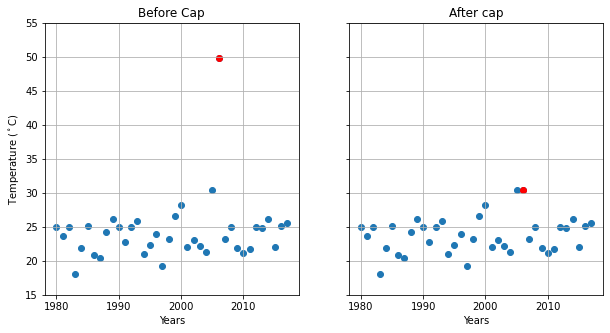

In [22]:
capped_outlier_dataset=np.copy(outlier_dataset)
print('Before cap the outlier, its value:\r\n',capped_outlier_dataset[outlier_loc])
# cap the outliers
capped_outlier_dataset[outlier_loc]=np.max(dropped_outlier_dataset)
print('After cap the outlier, its value:\r\n',capped_outlier_dataset[outlier_loc])

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before Cap')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After cap')
ax2.scatter(outlier_year,capped_outlier_dataset)
ax2.scatter(outlier_year[outlier_loc], capped_outlier_dataset[outlier_loc], c='r')
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

### 1.4.3.3 Replace it with a new value.
If an outlier seems to be due to a mistake in your data, you can try imputing another value. Common imputation methods include using the mean of a variable or utilizing a regression model to predict the missing value.

For example, we can replace it with the prediction value by a linear regression model.

Let's have a look how to do that in python.

Before replacing, the outlier value is:
 [49.9]
After replacing, the outlier value predicted by a regression model is: 
 [23.88835458]


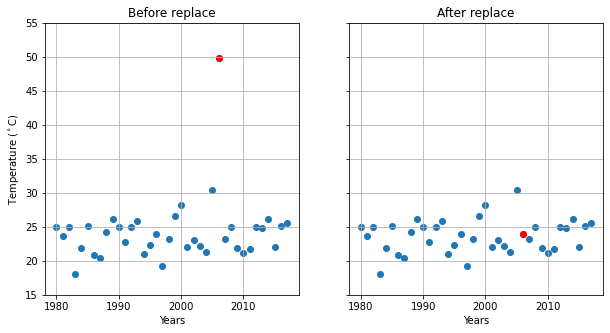

In [23]:
replaced_outlier_dataset = np.copy(outlier_dataset)
print('Before replacing, the outlier value is:\r\n',replaced_outlier_dataset[outlier_loc])

# find the coefficient of our linear model using clean data
z = np.polyfit(dropped_outlier_year,dropped_outlier_dataset, deg=1) # deg=1: use 1-order polynomial regression model
# define our linear model
pred_func = np.poly1d(z)
# predict the value of our outlier and replace it
pred_value = pred_func(outlier_year[outlier_loc])
replaced_outlier_dataset[outlier_loc]=pred_value
print('After replacing, the outlier value predicted by a regression model is: \r\n',replaced_outlier_dataset[outlier_loc])

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before replace')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc], outlier_dataset[outlier_loc], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After replace')
ax2.scatter(outlier_year,replaced_outlier_dataset)
ax2.scatter(outlier_year[outlier_loc], pred_value, c='r')
ax2.set_xlabel('Years')
ax2.grid()

plt.show()

**_[TO DO]_** Congratulations!!! You have learned the techniques needed to detect and deal with outliers. Now, try to detect and deal with outliers in the same dataset showed above, but:

- use the IQR score to detect the outliers
- use the temperature data for the months in which the outliers are found to predict and replace them.
- use a higher order polynomial (2nd or 3rd) to fit the data.

**HINT:** 

1. Find the years that contain outliers, the IQR score might give you different results compared to the z-score
2. Are all the data points detected by the IQR score TRUE outliers?
3. Check the data of the months in which the outliers are found to see if there are more (i.e. the maximum value being an outlier does not necessarily mean it is the only one in that month!)
4. Use the "good" data to fit a 2nd or 3rd order polynomial and estimate the outliers.

Before replacing, the outlier value is:
 [30.4 49.9]
After replacing, the outlier value predicted by a regression model is: 
 [23.46127816 23.50928811]


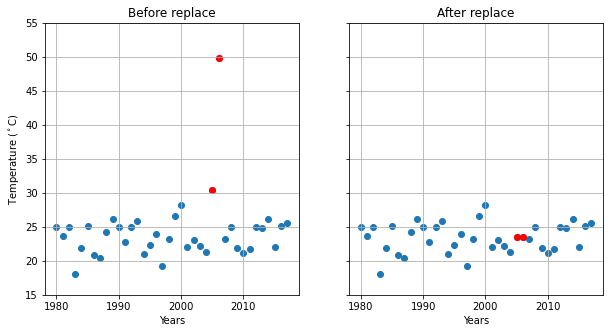

In [24]:
##########
# - use the IQR score to detect the outliers
# - use the temperature data for the months in which the outliers are found to predict and replace them.
# - use a higher order polynomial (2nd or 3rd) to fit the data.

# TO BE COMPLETED 
# find outlier locations by values which are equal to or above the smallest outlier
# this only works because the outliers in this case are higher than Q3
outlier_loc_IQR = np.where(outlier_dataset >= np.nanmin(outlier_by_IQR_Score))
print('Before replacing, the outlier value is:\r\n', outlier_dataset[outlier_loc_IQR])

#dropped_outlier_dataset_IQR = outlier_dataset[(outlier_dataset != outlier_by_IQR_Score[0]) & (outlier_dataset != outlier_by_IQR_Score[1])]
#dropped_outlier_year_IQR = outlier_year[(outlier_dataset != outlier_by_IQR_Score[0]) & (outlier_dataset != outlier_by_IQR_Score[1])]
#dropped_outlier_dataset_IQR = np.copy(outlier_dataset)
#dropped_outlier_year_IQR = np.copy(outlier_year)

dropped_outlier_dataset_IQR = outlier_dataset[(outlier_dataset < np.nanmin(outlier_by_IQR_Score))]
dropped_outlier_year_IQR = outlier_year[(outlier_dataset < np.nanmin(outlier_by_IQR_Score))]
#print(dropped_outlier_dataset_IQR)
#print(dropped_outlier_year_IQR)

replaced_outlier_dataset_IQR = np.copy(outlier_dataset)
replaced_outlier_year_IQR = outlier_year[(outlier_dataset >= np.nanmin(outlier_by_IQR_Score))]
#print(replaced_outlier_year_IQR)
# find the coefficient of our 2nd order polynomial using clean data
pred_func_2 = np.polyfit(dropped_outlier_year_IQR,dropped_outlier_dataset_IQR, deg=2) # deg=2: use 2-order polynomial regression model
# predict the value of our outlier and replace it
pred_val_2 = np.polyval(pred_func_2, replaced_outlier_year_IQR)
replaced_outlier_dataset_IQR[outlier_loc_IQR] = pred_val_2
print('After replacing, the outlier value predicted by a regression model is: \r\n',replaced_outlier_dataset_IQR[outlier_loc_IQR])

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.set_title('Before replace')
ax1.scatter(outlier_year,outlier_dataset)
ax1.scatter(outlier_year[outlier_loc_IQR], outlier_dataset[outlier_loc_IQR], c='r')
ax1.set_ylim([15, 55])
ax1.set_xlabel('Years')
ax1.set_ylabel(r'Temperature ($^\circ$C)')
ax1.grid()

ax2.set_title('After replace')
ax2.scatter(outlier_year,replaced_outlier_dataset_IQR)
ax2.scatter(outlier_year[outlier_loc_IQR], pred_val_2, c='r')
ax2.set_xlabel('Years')
ax2.grid()

plt.show()
##########################################################

## 1.5 Missing data

Resampling a dataset does not assure that no missing values will be found afterwards, because the interpolation method incurs in problems when many consecutive NaNs are encountered. In this case, you can see that there are some NaNs in the cities of Esbjerg and Roskilde, but what about the other cities? (remember we were only looking at the head of the dataset, but it actually has more than 330000 rows!)

**_[TO DO]_** count the number of missing values in each column of the dataset.

In [25]:
# task
#     count the number of missing values in each column of the dataset.

df_resampled.isnull().sum()

##############################

Aalborg   Temp            0
          Pressure        0
          WindSpeed       0
          WindDir         0
Aarhus    Temp            0
          Pressure        0
          WindSpeed       0
          WindDir         0
Esbjerg   Temp            1
          Pressure     1040
          WindSpeed       1
          WindDir         1
Odense    Temp            0
          Pressure        0
          WindSpeed       0
          WindDir         0
Roskilde  Temp            1
          Pressure      764
          WindSpeed       1
          WindDir         1
dtype: int64

In [26]:
df_test = df_resampled[df_resampled.index.year == 1982]
df_test.xs((cities[4], 'Pressure'), axis = 1).isnull().sum()

0

You can clearly see that the number of missing values is less than 0.5% and only for the pressure in Esbjerg and Roskilde. This does not affect the dataset as a whole, but since it is a time series, it can affect statistics on a yearly (or seasonal) time basis. 

Moreover, a second consideration about the linear interpolation in the resampling step is that the filling process might be deceiving.

**_[TO DO]_** As an example, plot only the signals that in the previous question contained a significant amount of missing values. Can you spot where the linear interpolation does not provide a reliable outcome?

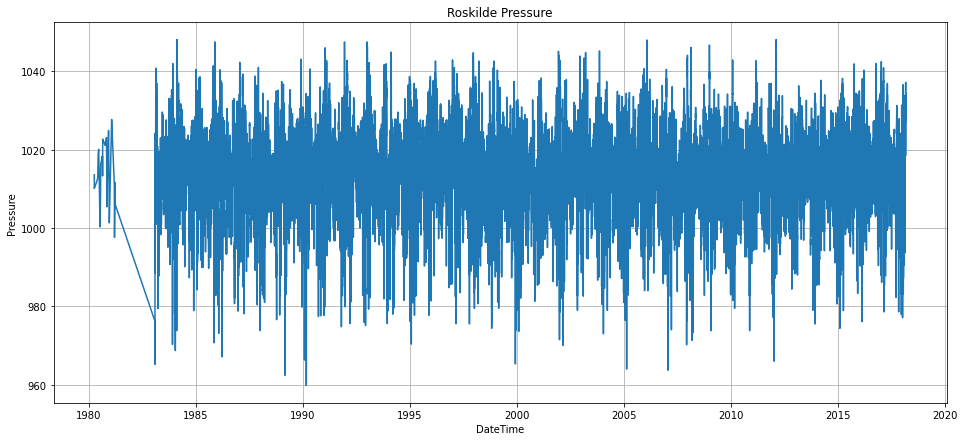

In [27]:
plt.figure(figsize=(16, 7))
#plt.plot(df_resampled['Esbjerg'].loc['1980-03-01 10:00:00':'1982-12-31 23:00:00','Pressure'],
        # label='Esbjerg')
plt.plot(df_resampled['Roskilde'].loc['1980-03-01 10:00:00':'2018-12-31 23:00:00','Pressure'])
plt.title('Roskilde Pressure')
plt.xlabel('DateTime')
plt.ylabel('Pressure')

#plt.ylim([-8, -2])
plt.grid()
plt.show()

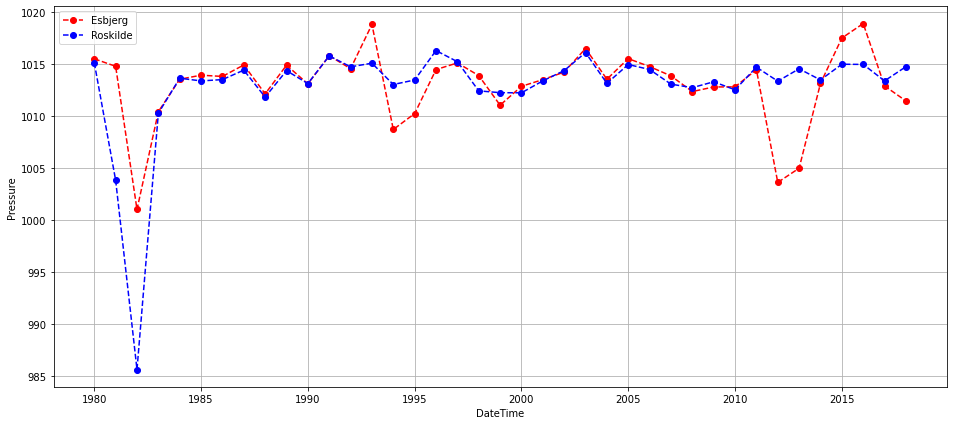

In [28]:
# TO DO

df_year = df_resampled.groupby(by = df_resampled.index.year).mean()

plt.figure(figsize=(16, 7))
plt.plot(df_year.xs((cities[2], 'Pressure'), axis = 1),
         label='Esbjerg', linestyle='--', marker='o',  c='r')

plt.plot(df_year.xs((cities[4], 'Pressure'), axis = 1),
         label='Roskilde', linestyle='--', marker='o',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Pressure')

#plt.ylim([-8, -2])
plt.grid()
plt.legend()
plt.show()
########################################

**_[TO DO]_** For just one of the two signals, produce a plot of the atmospheric pressure versus time and an histogram distribution for two different years:
- one with mostly "reliable" measurements
- one with an excessive amount of linearly interpolated values

Which differences can you see in those plots?

**HINT:** The typical value of the atmospheric pressure is around 1013 mbar and it has small variance. Therefore the distribution should be a Gaussian.

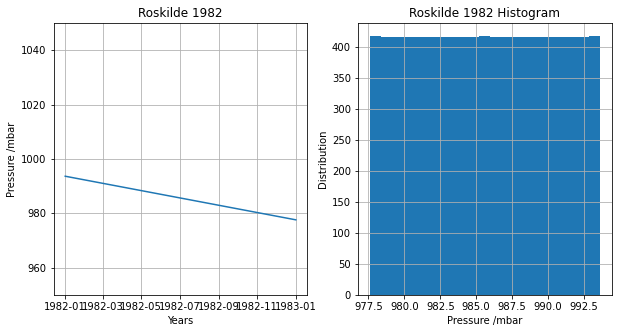

In [29]:
# [TO DO (1)] choose one year with many interpolated values, plot it and make an histogram of the distribution
# TO BE COMPLETED
df_interpol = df_resampled[df_resampled.index.year == 1982]

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 5))
ax1.set_title('Roskilde 1982')
ax1.plot(df_interpol.xs((cities[4], 'Pressure'), axis = 1))
ax1.set_ylim([950, 1050])
ax1.set_xlabel('Years')
ax1.set_ylabel('Pressure /mbar')
ax1.grid()

ax2.set_title('Roskilde 1982 Histogram')
ax2.hist(df_interpol.xs((cities[4], 'Pressure'), axis = 1), bins = 'auto')
ax2.set_xlabel('Pressure /mbar')
ax2.set_ylabel('Distribution')
ax2.grid()

plt.show()
###############################################

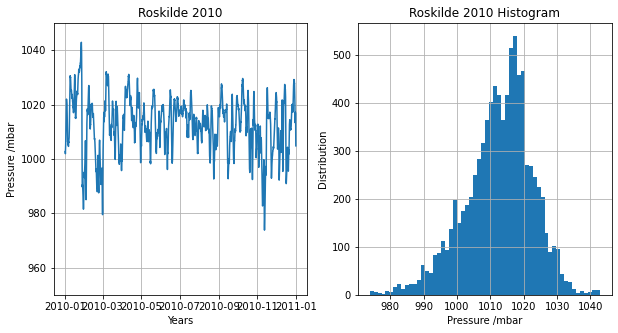

In [30]:
# [TO DO (2)] choose one year with mostly actual observations, plot it and make an histogram of the distribution
df_actual = df_resampled[df_resampled.index.year == 2010]

# plot and compare them
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 5))
ax1.set_title('Roskilde 2010')
ax1.plot(df_actual.xs((cities[4], 'Pressure'), axis = 1))
ax1.set_ylim([950, 1050])
ax1.set_xlabel('Years')
ax1.set_ylabel('Pressure /mbar')
ax1.grid()

ax2.set_title('Roskilde 2010 Histogram')
ax2.hist(df_actual.xs((cities[4], 'Pressure'), axis = 1), bins = 'auto')
ax2.set_xlabel('Pressure /mbar')
ax2.set_ylabel('Distribution')
ax2.grid()

plt.show()
# TO BE COMPLETED

### 1.5.1 Imputation of missing data points

Dealing with missing data points (or badly interpolated ones) is not easy. When missing data points are found, there are various approaches that we can consider:

- drop all of them (in this case is quite reasonable as they are only a few, percentage-wise).
- replace with the mean, median or mode. 
- replace with a fixed number, like -1 or 0.

Since we are dealing with a time series, none of these methods seems to be appropriate, especially the replacement. 
Therefore, we could generate this data by creating a predictive model that estimates the missing data from all the other input signals. Then we could fill the gaps by putting these generated values back into the data-set.

This process is also referred to as **imputation**. There are many ways to impute the missing values, one of the most powerful being the *MissForest* module inside the [missingpy](https://pypi.org/project/missingpy/) package (this package is not installed in the base Anaconda environment).

It basically fits a Random Forest (shallow machine learning algorithm) to the data and estimates all the missing values in each column feature. Here we only provide the code to run the MissForest algorithm (which is quite slow on Jupyter!).


As an example, we have pre-trained the MissForest in order to predict the pressure values in Roskilde in 1982 (all the data points are linearly interpolated).

You can see that the imputation consistently replicates how the pressure varies through the year, with a higher variance in winter and a lower one in summer. 

Feel free to install the *missingpy* package (you need to use pip, is not in the Anaconda repository) and try to replace the missing values and the badly interpolated ones.

In [31]:
df_Esbjerg_imputed = pd.read_pickle('./weather-data/weather_Esbjerg_imputed.zip.pkl', compression = 'zip')

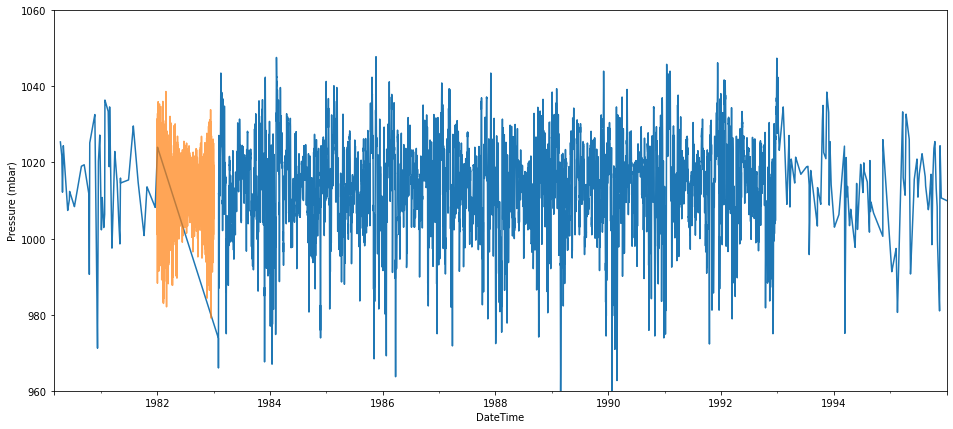

In [32]:
plt.figure(figsize=(16, 7))
df_resampled['Esbjerg'].loc['1980-03-01 10:00:00':'1995-12-31 23:00:00','Pressure'].plot()
df_Esbjerg_imputed.loc['1982-01-01 00:00:00':'1982-12-31 23:00:00','Pressure'].plot(alpha=0.7)

plt.ylim([960, 1060])
plt.ylabel('Pressure (mbar)')
plt.show()